# TensorFlow Models

In [1]:
import os
import datetime
import random

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

os.chdir(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions')
import auxiliaries as aux
os.chdir(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels')

In [2]:
tf.__version__

'2.16.2'

## Setup

In [3]:
# Develop Testing and Applied Window
species = 'Moose'
file_name = 'yl1'

tf_tut_window = aux.WindowGenerator(input_width=aux.OUT_STEPS,
                               label_width=aux.OUT_STEPS,
                               shift=aux.OUT_STEPS,
                               cv_name=f'{species}/{file_name}')

reg_window = aux.RegressiveWindow(f'{species}/{file_name}')
classification_window = aux.ClassificationWindow(f'{species}/{file_name}', 3)
rnn_window = aux.RNNWindow(f'{species}/{file_name}')

results = {}

print(f'{species}:')
print('------Tensorflow Tutorial Window------')
print(f'Original Data Size: {len(tf_tut_window.orig_df)}')
print(f'Training Data Size: {len(tf_tut_window.train_df)}')
print(f'Validation Data Size: {len(tf_tut_window.val_df)}')
print(f'Testing Data Size: {len(tf_tut_window.test_df)}')

print()

print('------Regressive Model Window------')
print(f'Original Data Size: {len(reg_window.orig_df)}')
print(f'Training Data Size: {int(len(reg_window.train_df)*(7/9))}')
print(f'Validation Data Size: {int(len(reg_window.train_df)*(2/9))}')
print(f'Testing Data Size: {len(reg_window.test_df)}')

print()

print('------Classification Model Window------')
print(f'Original Data Size: {len(classification_window.orig_df)}')
print(f'Training Data Size: {int(len(classification_window.train_df)*(7/9))}')
print(f'Validation Data Size: {int(len(classification_window.train_df)*(2/9))}')
print(f'Testing Data Size: {len(classification_window.test_df)}')

Moose:
------Tensorflow Tutorial Window------
Original Data Size: 7692
Training Data Size: 5384
Validation Data Size: 1538
Testing Data Size: 770

------Regressive Model Window------
Original Data Size: 7692
Training Data Size: 5384
Validation Data Size: 1538
Testing Data Size: 769

------Classification Model Window------
Original Data Size: 7692
Training Data Size: 5384
Validation Data Size: 1538
Testing Data Size: 769


## Autoregressive Model

- Good start
- Very inaccurate

In [4]:
autoregressive_model = aux.FeedBack(units=32, out_steps=aux.OUT_STEPS, num_vars=3)

In [5]:
history = aux.compile_and_fit(autoregressive_model, tf_tut_window)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - loss: 0.7772 - mean_absolute_error: 0.6876 - mean_squared_error: 0.7772 - val_loss: 0.6181 - val_mean_absolute_error: 0.5758 - val_mean_squared_error: 0.6181
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.5906 - mean_absolute_error: 0.5595 - mean_squared_error: 0.5906 - val_loss: 0.5576 - val_mean_absolute_error: 0.5381 - val_mean_squared_error: 0.5576
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.5338 - mean_absolute_error: 0.5237 - mean_squared_error: 0.5338 - val_loss: 0.5638 - val_mean_absolute_error: 0.5695 - val_mean_squared_error: 0.5638
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.5564 - mean_absolute_error: 0.5402 - mean_squared_error: 0.5564 - val_loss: 0.5530 - val_mean_absolute_error: 0.5448 - val_mean_squared_error: 0.5530
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.5129 - mean_absolute_error: 0.5096 - mean_squared_error: 0.5129 - val_loss: 0.5167 -

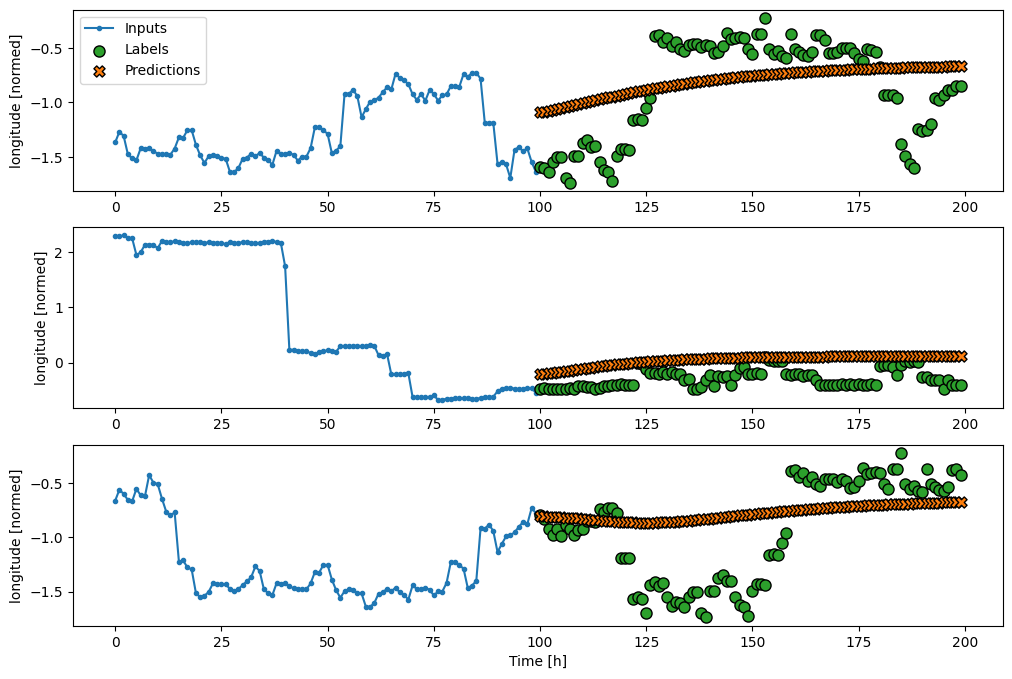

In [6]:
tf_tut_window.plot(autoregressive_model, plot_col='longitude')

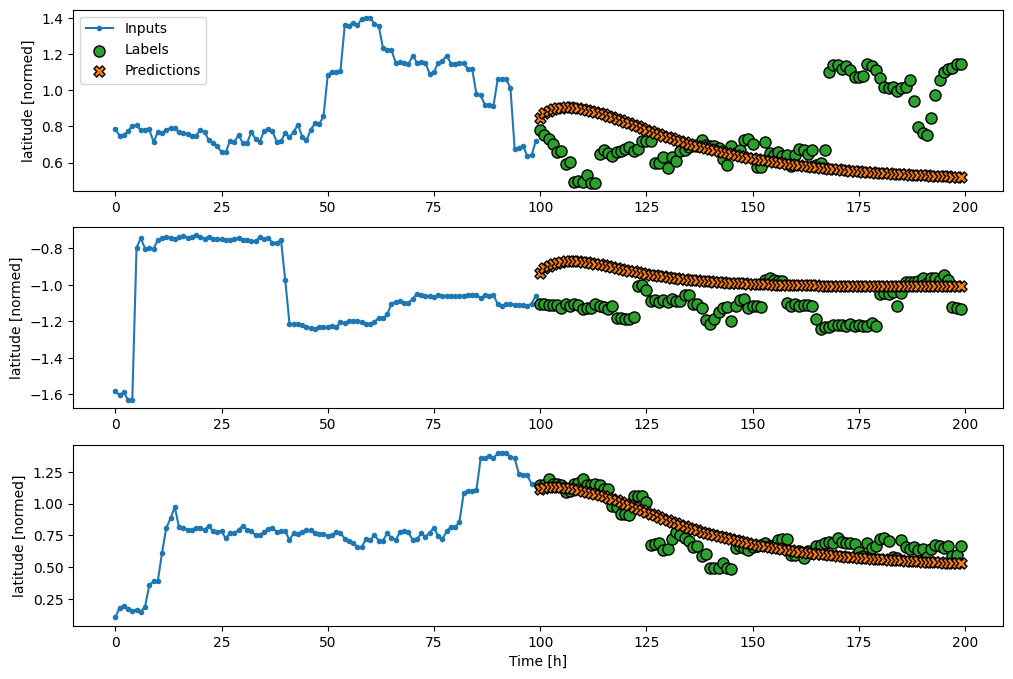

In [7]:
tf_tut_window.plot(autoregressive_model, plot_col='latitude')

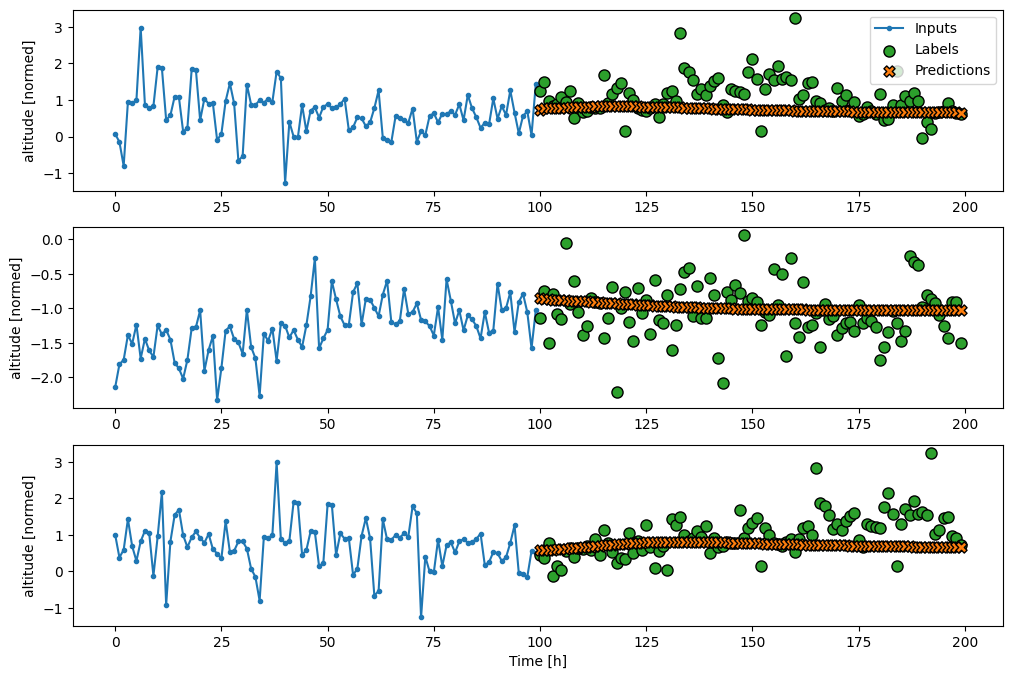

In [8]:
tf_tut_window.plot(autoregressive_model, plot_col='altitude')

In [9]:
results['Autoregressive'] = autoregressive_model.evaluate(tf_tut_window.test, verbose=1, return_dict=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5369 - mean_absolute_error: 0.9357 - mean_squared_error: 1.5369


In [10]:
autoregressive_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_autoregressive.keras')
tf_tut_window.extend_to_csv(url_dest=f'{species}/{file_name}_autoregressive', species=species, model=autoregressive_model)

In [11]:
def graph_tf_tutorial(model, window, url_dest):
    input_data, label_data = next(iter(window.edge_data))

    predicted_data = pd.DataFrame(model(input_data)[0].numpy(), columns=window.edge_df.columns)*window.train_std + window.train_mean
    input_data = pd.DataFrame(input_data[0].numpy(), columns=window.edge_df.columns)*window.train_std + window.train_mean
    label_data = pd.DataFrame(label_data[0].numpy(), columns=window.edge_df.columns)*window.train_std + window.train_mean

    input_data['timestamp'] = window.date_time.iloc[-(2*aux.OUT_STEPS):-aux.OUT_STEPS].reset_index(drop=True)
    label_data['timestamp'] = window.date_time.iloc[-aux.OUT_STEPS:].reset_index(drop=True)
    predicted_data['timestamp'] = window.date_time.iloc[-aux.OUT_STEPS:].reset_index(drop=True)

    input_data['id'] = ['input' for _ in range(len(input_data))]
    label_data['id'] = ['label' for _ in range(len(label_data))]
    predicted_data['id'] = ['predicted' for _ in range(len(predicted_data))]

    full_df = pd.concat([input_data, label_data, predicted_data], ignore_index=True)
    full_df.to_csv(url_dest, index=False)

    return full_df

autoregressive_model = tf.keras.models.load_model(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\ModelCreation\SavedModels\Moose\yl1_autoregressive.keras', custom_objects={'FeedBack':aux.FeedBack})

graph_tf_tutorial(autoregressive_model, tf_tut_window, f'TestCSV/{species}/{file_name}_autoregressive_EdgeAnalysis.csv')

,longitude,latitude,altitude,timestamp,id
0,-111.387324,57.399642,296.550000,2012-10-02 01:00:53,input
1,-111.369510,57.427271,322.410000,2012-10-02 07:00:47,input
2,-111.369607,57.427383,314.390000,2012-10-02 10:00:47,input
3,-111.369955,57.427469,316.600000,2012-10-02 13:00:43,input
4,-111.369106,57.430020,315.440000,2012-10-02 16:00:52,input
...,...,...,...,...,...
295,-111.430039,57.389015,311.244575,2012-10-28 04:02:23,predicted
296,-111.430050,57.388837,311.186473,2012-10-28 07:00:49,predicted
297,-111.430055,57.388667,311.128760,2012-10-28 10:00:53,predicted
298,-111.430054,57.388507,311.071609,2012-10-28 13:00:44,predicted


## RNN Single Shot Model

In [12]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(aux.OUT_STEPS*len(tf_tut_window.column_indices),
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([aux.OUT_STEPS, len(tf_tut_window.column_indices)])
])

history = aux.compile_and_fit(multi_lstm_model, tf_tut_window)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.8196 - mean_absolute_error: 0.7090 - mean_squared_error: 0.8196 - val_loss: 0.5540 - val_mean_absolute_error: 0.5634 - val_mean_squared_error: 0.5540
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.5159 - mean_absolute_error: 0.5234 - mean_squared_error: 0.5159 - val_loss: 0.4813 - val_mean_absolute_error: 0.5155 - val_mean_squared_error: 0.4813
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.4606 - mean_absolute_error: 0.4830 - mean_squared_error: 0.4606 - val_loss: 0.4756 - val_mean_absolute_error: 0.5048 - val_mean_squared_error: 0.4756
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.4352 - mean_absolute_error: 0.4643 - mean_squared_error: 0.4352 - val_loss: 0.4706 - val_mean_absolute_error: 0.5039 - val_mean_squared_error: 0.4706
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.4220 - mean_absolute_error: 0.4585 - mean_squared_error: 0.4220 - val_loss: 0.4391 -

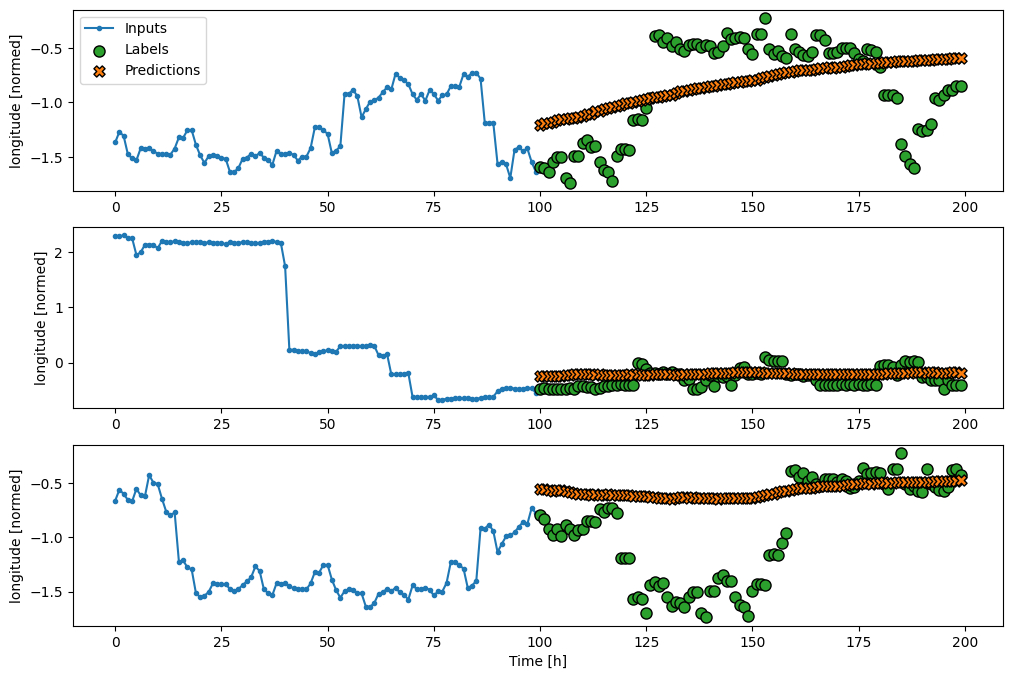

In [13]:
tf_tut_window.plot(multi_lstm_model, plot_col='longitude')

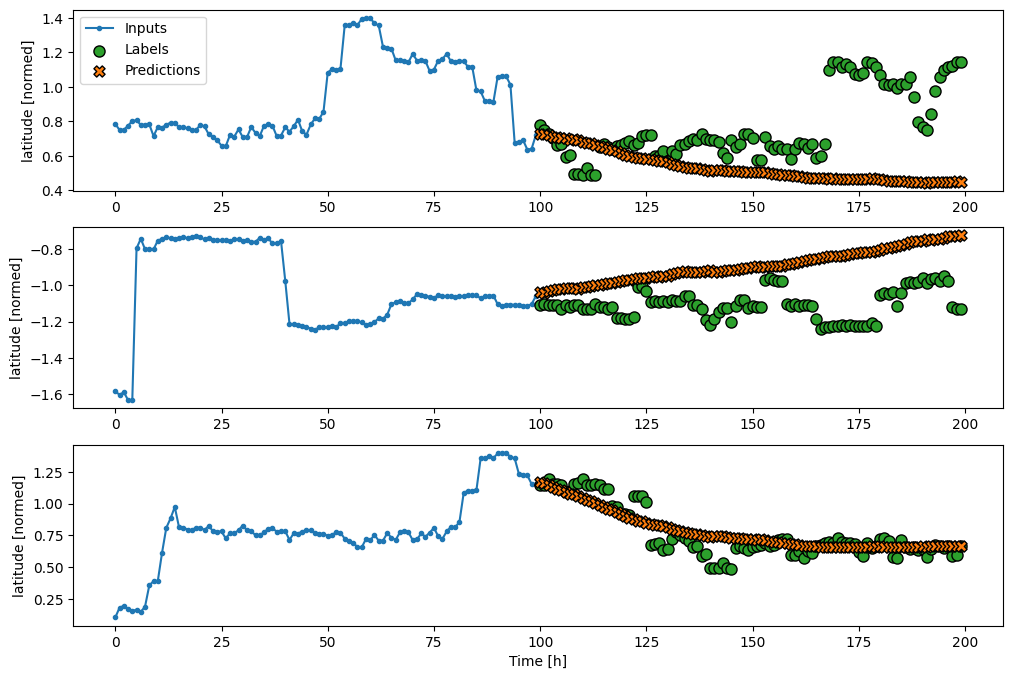

In [14]:
tf_tut_window.plot(multi_lstm_model, plot_col='latitude')

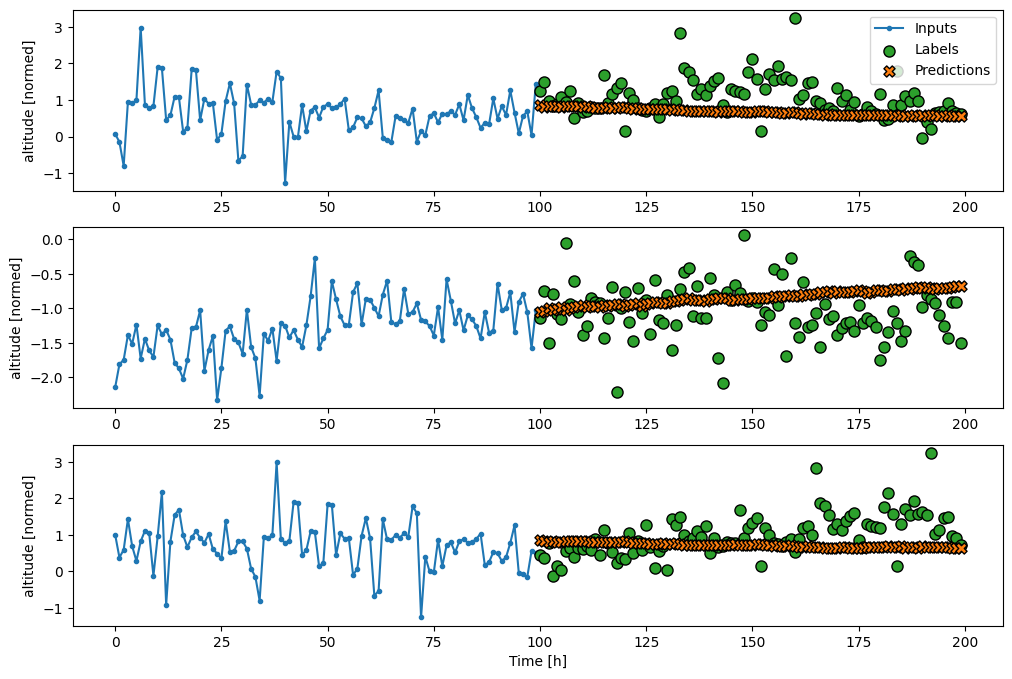

In [15]:
tf_tut_window.plot(multi_lstm_model, plot_col='altitude')

In [16]:
results['Single Shot'] = multi_lstm_model.evaluate(tf_tut_window.test, verbose=1, return_dict=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9061 - mean_absolute_error: 0.7011 - mean_squared_error: 0.9061


In [17]:
tf_tut_window.extend_to_csv(url_dest=f'{species}/{file_name}_singleshot', species=species, model=multi_lstm_model)
multi_lstm_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_singleshot.keras')

In [18]:
graph_tf_tutorial(multi_lstm_model, tf_tut_window, f'TestCSV/{species}/{file_name}_singleshot_EdgeAnalysis.csv')

,longitude,latitude,altitude,timestamp,id
0,-111.387324,57.399642,296.550000,2012-10-02 01:00:53,input
1,-111.369510,57.427271,322.410000,2012-10-02 07:00:47,input
2,-111.369607,57.427383,314.390000,2012-10-02 10:00:47,input
3,-111.369955,57.427469,316.600000,2012-10-02 13:00:43,input
4,-111.369106,57.430020,315.440000,2012-10-02 16:00:52,input
...,...,...,...,...,...
295,-111.409482,57.414607,302.210251,2012-10-28 04:02:23,predicted
296,-111.410055,57.414222,302.258531,2012-10-28 07:00:49,predicted
297,-111.410297,57.414156,303.055651,2012-10-28 10:00:53,predicted
298,-111.410795,57.413846,302.389619,2012-10-28 13:00:44,predicted


## Regressive Model

In [19]:
regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1,3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)
])

reg_window.model_compilation_and_fitting(regressive_model)

Epoch 1/20


c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7834 - mean_absolute_error: 0.7063 - mean_squared_error: 0.7834 - val_loss: 0.6845 - val_mean_absolute_error: 0.6560 - val_mean_squared_error: 0.6845
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6621 - mean_absolute_error: 0.6458 - mean_squared_error: 0.6621 - val_loss: 0.6153 - val_mean_absolute_error: 0.6186 - val_mean_squared_error: 0.6153
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5982 - mean_absolute_error: 0.6074 - mean_squared_error: 0.5982 - val_loss: 0.5856 - val_mean_absolute_error: 0.6008 - val_mean_squared_error: 0.5856
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5669 - mean_absolute_error: 0.5872 - mean_squared_error: 0.5669 - val_loss: 0.5685 - val_mean_absolute_error: 0.5851 - val_mean_squared_error: 0.5685
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5537 - mean_absolute_error: 0.5751 - mean_squared_error: 0.5537 - val_loss: 0.5346 - val_mean_absolut

In [20]:
regressive_model(reg_window.train_input)*reg_window.train_df[['longitude', 'latitude', 'altitude']].std() + reg_window.train_df[['longitude', 'latitude', 'altitude']].mean()

<tf.Tensor: shape=(6923, 1, 3), dtype=float32, numpy=
array([[[-111.419464,   57.34453 ,  278.2761  ]],

       [[-111.4338  ,   57.379425,  315.21814 ]],

       [[-111.42667 ,   57.37006 ,  307.90265 ]],

       ...,

       [[-111.41285 ,   57.367897,  306.76392 ]],

       [[-111.348045,   57.456425,  275.03552 ]],

       [[-111.36443 ,   57.448227,  281.80115 ]]], dtype=float32)>

In [21]:
reg_window.train_input.shape

(6923, 1, 3)

In [22]:
results['Regressive Model'] = regressive_model.evaluate(reg_window.test_input, reg_window.test_label, verbose=1, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3810 - mean_absolute_error: 0.4495 - mean_squared_error: 0.3810 


In [23]:
reg_window.csv_extension(f'{species}/{file_name}_regressive', species, regressive_model)

In [24]:
regressive_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_regressive.keras')

In [25]:
def graph_regressive(model, window, url_dest):
    orig_df = window.orig_df
    orig_df['timestamp'] = window.timeline

    initial_df = orig_df.iloc[-aux.OUT_STEPS:][['timestamp', 'month', 'day', 'external-temperature', 'longitude', 'latitude', 'altitude']]
    initial_df['id'] = ['original' for _ in range(len(initial_df))]

    data = {
        'timestamp': [],
        'month': [],
        'day': [],
        'external-temperature': [],
        'longitude': [],
        'latitude': [],
        'altitude': [],
        'id': []
    }

    for i in range(len(initial_df)):
        section = initial_df.iloc[i]

        timestamp = section['timestamp']
        month = section['month']
        day = section['day']
        external_temp = section['external-temperature']

        output_fields = model(np.array([(external_temp - window.train_df.mean()['external-temperature'])/window.train_df.std()['external-temperature'], 
                                        (month - window.train_df.mean()['month'])/window.train_df.std()['month'], 
                                        (day - window.train_df.mean()['day'])/window.train_df.std()['day']]).reshape([1, 1, 3]))*window.train_df[['longitude', 'latitude', 'altitude']].std() + window.train_df[['longitude', 'latitude', 'altitude']].mean()
        output_fields = output_fields.numpy()[0][0]

        longitude = output_fields[0]
        latitude = output_fields[1]
        altitude = output_fields[2]
        id = 'predicted'

        data['timestamp'].append(timestamp)
        data['month'].append(month)
        data['day'].append(day)
        data['external-temperature'].append(external_temp)
        data['longitude'].append(longitude)
        data['latitude'].append(latitude)
        data['altitude'].append(altitude)
        data['id'].append(id)

    add_on_df = pd.DataFrame(data)
    
    full_df = pd.concat([initial_df, add_on_df], ignore_index=True)
    full_df.to_csv(url_dest, index=False)

    return full_df

graph_regressive(regressive_model, reg_window, f'TestCSV/{species}/{file_name}_regressive_EdgeAnalysis.csv')

,timestamp,month,day,external-temperature,longitude,latitude,altitude,id
0,2012-10-14 19:01:21,10,14,10.0,-111.330400,57.458743,255.680000,original
1,2012-10-14 22:00:54,10,14,13.0,-111.330776,57.458470,264.380000,original
2,2012-10-15 01:00:56,10,15,11.0,-111.331893,57.461901,273.240000,original
3,2012-10-15 04:00:50,10,15,10.0,-111.329811,57.462023,265.740000,original
4,2012-10-15 07:00:44,10,15,11.0,-111.329559,57.461996,281.920000,original
...,...,...,...,...,...,...,...,...
195,2012-10-28 04:02:23,10,28,-2.0,-111.368324,57.446270,286.221313,predicted
196,2012-10-28 07:00:49,10,28,-1.0,-111.362411,57.450191,283.624634,predicted
197,2012-10-28 10:00:53,10,28,-2.0,-111.368324,57.446270,286.221313,predicted
198,2012-10-28 13:00:44,10,28,0.0,-111.357643,57.453026,281.585602,predicted


## RNN Recursive Model

In [26]:
rnn_regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(aux.OUT_STEPS*3,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([aux.OUT_STEPS, 3])
])

rnn_window.model_compilation_and_fitting(rnn_regressive_model)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9708 - mean_absolute_error: 0.7992 - mean_squared_error: 0.9708 - val_loss: 0.9312 - val_mean_absolute_error: 0.7983 - val_mean_squared_error: 0.9312
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8160 - mean_absolute_error: 0.7124 - mean_squared_error: 0.8160 - val_loss: 0.9389 - val_mean_absolute_error: 0.7799 - val_mean_squared_error: 0.9389
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7819 - mean_absolute_error: 0.6886 - mean_squared_error: 0.7819 - val_loss: 0.9329 - val_mean_absolute_error: 0.7649 - val_mean_squared_error: 0.9329


In [27]:
rnn_window.train_input.shape

(6922, 1, 3)

In [28]:
rnn_window.train_label.shape

(6922, 1, 3)

In [29]:
rnn_regressive_model(rnn_window.train_input)*rnn_window.train_df[['longitude', 'latitude', 'altitude']].std() + rnn_window.train_df[['longitude', 'latitude', 'altitude']].mean()

<tf.Tensor: shape=(6922, 100, 3), dtype=float32, numpy=
array([[[-111.397484,   57.348793,  286.27347 ],
        [-111.397484,   57.348793,  286.27347 ],
        [-111.397484,   57.348793,  286.27347 ],
        ...,
        [-111.397484,   57.348793,  286.27347 ],
        [-111.397484,   57.348793,  286.27347 ],
        [-111.397484,   57.348793,  286.27347 ]],

       [[-111.39715 ,   57.350266,  287.25577 ],
        [-111.39715 ,   57.350266,  287.25577 ],
        [-111.39715 ,   57.350266,  287.25577 ],
        ...,
        [-111.39715 ,   57.350266,  287.25577 ],
        [-111.39715 ,   57.350266,  287.25577 ],
        [-111.39715 ,   57.350266,  287.25577 ]],

       [[-111.39652 ,   57.353077,  289.13052 ],
        [-111.39652 ,   57.353077,  289.13052 ],
        [-111.39652 ,   57.353077,  289.13052 ],
        ...,
        [-111.39652 ,   57.353077,  289.13052 ],
        [-111.39652 ,   57.353077,  289.13052 ],
        [-111.39652 ,   57.353077,  289.13052 ]],

       ...,

    

In [30]:
results['RNN Regressive Model'] = rnn_regressive_model.evaluate(rnn_window.test_input, rnn_window.test_label, verbose=1, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8706 - mean_absolute_error: 0.7483 - mean_squared_error: 0.8706


In [31]:
rnn_window.csv_extension(f'{species}/{file_name}_RNN_regressive', species, rnn_regressive_model)

In [32]:
rnn_regressive_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_RNN_regressive.keras')

In [33]:
def graph_rnn_regressive(model, window:aux.RNNWindow, url_dest):
    # Isolate OUTSTEP
    initial_df = window.orig_df.iloc[-aux.OUT_STEPS:]
    initial_df['timestamp'] = window.timeline[-aux.OUT_STEPS:]

    # Gather Data
    input_data = (initial_df[['external-temperature', 'month', 'day']] - window.train_df[['external-temperature', 'month', 'day']].mean())/window.train_df[['external-temperature', 'month', 'day']].std()
    predicted_data = model(np.array(input_data.values).reshape((1, aux.OUT_STEPS, 3)))[0]*window.train_df[['longitude', 'latitude', 'altitude']].std() + window.train_df[['longitude', 'latitude', 'altitude']].mean()

    # 
    input_df = initial_df[['timestamp', 'external-temperature', 'month', 'day']].reset_index()
    label_df = pd.DataFrame(predicted_data, columns=['longitude', 'latitude', 'altitude'])

    add_on_df = pd.concat([input_df, label_df], axis=1).drop(columns='index')

    final_df = pd.concat([initial_df, add_on_df], axis=0, ignore_index=True)[['timestamp', 'external-temperature', 'month', 'day', 'longitude', 'latitude', 'altitude']]

    final_df.to_csv(url_dest, index=False)

    return final_df
    

graph_rnn_regressive(rnn_regressive_model, rnn_window, f'TestCSV/{species}/{file_name}_RNN_regressive_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_40896\2497186959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df['timestamp'] = window.timeline[-aux.OUT_STEPS:]


,timestamp,external-temperature,month,day,longitude,latitude,altitude
0,2012-10-14 19:01:21,10.0,10,14,-111.330400,57.458743,255.680000
1,2012-10-14 22:00:54,13.0,10,14,-111.330776,57.458470,264.380000
2,2012-10-15 01:00:56,11.0,10,15,-111.331893,57.461901,273.240000
3,2012-10-15 04:00:50,10.0,10,15,-111.329811,57.462023,265.740000
4,2012-10-15 07:00:44,11.0,10,15,-111.329559,57.461996,281.920000
...,...,...,...,...,...,...,...
195,2012-10-28 04:02:23,-2.0,10,28,-111.422493,57.423046,323.322205
196,2012-10-28 07:00:49,-1.0,10,28,-111.422493,57.423046,323.322205
197,2012-10-28 10:00:53,-2.0,10,28,-111.422493,57.423046,323.322205
198,2012-10-28 13:00:44,0.0,10,28,-111.422493,57.423046,323.322205


## Classification Model

In [34]:
classification_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1, 3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(classification_window.n_clusters, activation='softmax'),
])

classification_window.model_compilation_and_fitting(classification_model)

Epoch 1/20


c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.2099 - mean_absolute_error: 0.8973 - mean_squared_error: 1.2099 - val_loss: 1.1997 - val_mean_absolute_error: 0.8917 - val_mean_squared_error: 1.1997
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1991 - mean_absolute_error: 0.8903 - mean_squared_error: 1.1991 - val_loss: 1.1997 - val_mean_absolute_error: 0.8917 - val_mean_squared_error: 1.1997
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1798 - mean_absolute_error: 0.8812 - mean_squared_error: 1.1798 - val_loss: 1.1997 - val_mean_absolute_error: 0.8917 - val_mean_squared_error: 1.1997


In [35]:
classification_model(classification_window.test_input)

<tf.Tensor: shape=(769, 1, 3), dtype=float32, numpy=
array([[[0.33367318, 0.33287084, 0.333456  ]],

       [[0.3336443 , 0.33332327, 0.3330324 ]],

       [[0.33352914, 0.3334291 , 0.3330418 ]],

       ...,

       [[0.3324986 , 0.33343977, 0.33406162]],

       [[0.3324986 , 0.33343977, 0.33406162]],

       [[0.33267328, 0.33317095, 0.33415577]]], dtype=float32)>

In [36]:
results['Classification Model'] = classification_model.evaluate(classification_window.test_input, classification_window.test_label, verbose=1, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9245 - mean_absolute_error: 0.7507 - mean_squared_error: 0.9245 


In [37]:
classification_window.csv_extension(f'{species}/{file_name}_classification', species, classification_model)

C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions\auxiliaries.py:403: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['longitude'].append(point[0])
C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions\auxiliaries.py:404: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['latitude'].append(point[1])
C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions\auxiliaries.py:403: FutureWarning: Series.__getitem__ treating keys as positions is deprec

In [38]:
classification_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_classification.keras')

In [39]:
def graph_classifcation(model, window, url_dest):
    orig_df = window.orig_df
    orig_df['timestamp'] = window.timeline

    initial_df = orig_df.iloc[-aux.OUT_STEPS:][['timestamp', 'month', 'day', 'external-temperature', 'longitude', 'latitude', 'altitude']]
    initial_df['id'] = ['original' for _ in range(len(initial_df))]
    initial_df['label'] = window.k_means.predict(initial_df[['longitude', 'latitude']].values)

    data = {
        'timestamp': [],
        'month': [],
        'day': [],
        'external-temperature': [],
        'longitude': [],
        'latitude': [],
        'altitude': [],
        'label': [],
        'id': []
    }

    for i in range(len(initial_df)):
        section = initial_df.iloc[i]

        timestamp = section['timestamp']
        month = section['month']
        day = section['day']
        external_temp = section['external-temperature']

        output_field = model(np.array([(external_temp - window.train_df.mean()['external-temperature'])/window.train_df.std()['external-temperature'],
                                        (month - window.train_df.mean()['month'])/window.train_df.std()['month'],
                                        (day - window.train_df.mean()['day'])/window.train_df.std()['day']]).reshape((1, 1, 3)))
        
        label = max(range(window.n_clusters), key = lambda x: output_field[0][0][x])
        point = window.clusters[label]*window.train_df[['longitude', 'latitude']].std() + window.train_df[['longitude', 'latitude']].mean()
        
        data['timestamp'].append(timestamp)
        data['longitude'].append(point[0])
        data['latitude'].append(point[1])
        data['altitude'].append(window.altitude_model.predict([point])[0]*window.train_df.std()['altitude'] + window.train_df.mean()['altitude'])
        data['external-temperature'].append(external_temp)
        data['month'].append(month)
        data['day'].append(day)
        data['label'].append(label)
        data['id'].append('predicted')
    
    add_on_df = pd.DataFrame(data)

    full_df = pd.concat([initial_df, add_on_df], ignore_index=True)

    full_df.to_csv(url_dest, index=False)

    return full_df

graph_classifcation(classification_model, classification_window, f'TestCSV/{species}/{file_name}_classification_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_40896\2968565651.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['longitude'].append(point[0])
C:\Users\Imper\AppData\Local\Temp\ipykernel_40896\2968565651.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['latitude'].append(point[1])
C:\Users\Imper\AppData\Local\Temp\ipykernel_40896\2968565651.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['longitude'].append(

,timestamp,month,day,external-temperature,longitude,latitude,altitude,id,label
0,2012-10-14 19:01:21,10,14,10.0,-111.330400,57.458743,255.680,original,2
1,2012-10-14 22:00:54,10,14,13.0,-111.330776,57.458470,264.380,original,2
2,2012-10-15 01:00:56,10,15,11.0,-111.331893,57.461901,273.240,original,2
3,2012-10-15 04:00:50,10,15,10.0,-111.329811,57.462023,265.740,original,2
4,2012-10-15 07:00:44,10,15,11.0,-111.329559,57.461996,281.920,original,2
...,...,...,...,...,...,...,...,...,...
195,2012-10-28 04:02:23,10,28,-2.0,-111.435164,57.383868,316.944,predicted,2
196,2012-10-28 07:00:49,10,28,-1.0,-111.435164,57.383868,316.944,predicted,2
197,2012-10-28 10:00:53,10,28,-2.0,-111.435164,57.383868,316.944,predicted,2
198,2012-10-28 13:00:44,10,28,0.0,-111.435164,57.383868,316.944,predicted,2


In [40]:
def graph_clusters(window:aux.ClassificationWindow, url_dest):
    orig_df = window.orig_df
    orig_df['timestamp'] = window.timeline

    input_val = (orig_df[['longitude', 'latitude']] - orig_df[['longitude', 'latitude']].mean())/orig_df[['longitude', 'latitude']].std()

    orig_df['label'] = window.k_means.predict(input_val.values)
    clusters = window.clusters*window.train_df[['longitude', 'latitude']].std().values + window.train_df[['longitude', 'latitude']].mean().values
    orig_df['label'] = orig_df['label'].map(lambda x: str(clusters[x]))

    orig_df = orig_df[['timestamp', 'external-temperature', 'month', 'day', 'longitude', 'latitude', 'altitude', 'label']]

    orig_df.to_csv(url_dest, index=False)
    
    return orig_df

graph_clusters(classification_window, f'TestCSV/{species}/{file_name}_classification_clustering_groups.csv')

,timestamp,external-temperature,month,day,longitude,latitude,altitude,label
0,2010-03-06 01:00:54,7.0,3,6,-111.399967,57.371726,310.47,[-111.39609286 57.34687994]
1,2010-03-06 04:00:53,6.0,3,6,-111.399996,57.371528,303.22,[-111.39609286 57.34687994]
2,2010-03-06 07:00:53,4.0,3,6,-111.400058,57.371440,290.53,[-111.39609286 57.34687994]
3,2010-03-06 10:02:22,2.0,3,6,-111.399977,57.372240,310.64,[-111.39609286 57.34687994]
4,2010-03-06 13:01:07,2.0,3,6,-111.400137,57.372234,314.64,[-111.39609286 57.34687994]
...,...,...,...,...,...,...,...,...
7687,2012-10-28 04:02:23,-2.0,10,28,-111.369381,57.427532,302.60,[-111.35752352 57.44151344]
7688,2012-10-28 07:00:49,-1.0,10,28,-111.369681,57.425542,313.71,[-111.35752352 57.44151344]
7689,2012-10-28 10:00:53,-2.0,10,28,-111.399337,57.401407,321.63,[-111.43516404 57.3838685 ]
7690,2012-10-28 13:00:44,0.0,10,28,-111.399689,57.401398,311.56,[-111.43516404 57.3838685 ]


## Final Results

In [41]:
results_df = pd.DataFrame(results).T
results_df.to_csv(f'ModelCreation/results/{species}/{file_name}_test_data.csv', index_label='Model_Name')
results_df

,loss,mean_absolute_error,mean_squared_error
Autoregressive,1.464251,0.905626,1.464251
Single Shot,0.900697,0.698556,0.900697
Regressive Model,0.436928,0.493163,0.436928
RNN Regressive Model,1.472849,0.973040,1.472849
Classification Model,1.183066,0.883398,1.183066
